## How do choices in our neural network affect the performance of the model?

Previsously, we looked at how a neural (NN) and non-neural (non-NN) network can be utilised to classify data within a dataset - specifically the classes of objects within the SDSS DR18 dataset. In our notebooks we compared each approach to each other and worked on optimisation of our networks. This notebook aims to look further into that, specifically to answer the following questions: 

1) How does the amount of training data used affect the performance of the NN?
2) How does the balance of classes in a classification problem affect the performance of a neural network?

We aim to answer both these questions in this notebook - whilst assuming both prior notebooks have been read so the reader has a level of understanding as to how the NN and non-NN both operate. We will look to explore how changing the amount of training data can cause issues with the model - e.g. over and underfitting, and to explore the effects of imbalance of classes and how we can potentially resolve these issues within our modelling.

## Importing the libraries and reading the data ##

In [1]:
import kagglehub #used to get the data from kaggle.com
from kagglehub import KaggleDatasetAdapter #used to fetch the specific dataset from kaggle
import pandas as pd #used for viewing and manipulating the data
import matplotlib.pyplot as plt #used for data visulisation
import numpy as np

import torch
import torch.nn as nn #used to create neural network
import torch.optim as optim #used to optimise neural network

from torch.utils.data import DataLoader, TensorDataset #import DataLoader and TensorDataset from pytorch
from sklearn.model_selection import train_test_split as skl_tts #imports train_test_split as skl_tts from sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler #imports LabelEncoder and StandardScaler from sklearn
from sklearn.metrics import classification_report as skl_cr #imports classification_report as skl_cr from sklearn
import seaborn as sns #imports seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay #imports confusion_matrix and ConfusionMatrixDisplay from sklearn

import sys, os #imports sys and os, allows for modifying the path to get functions
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), ".."))) #changes the path to include the py folder and its contents (parent folder)

from functions import * #calls all functions from functions.py

In [2]:
data = dataGrabber() #reads in data from dataGrabber function

## 1. Affects of changing the amounts of training data on the Neural Network

As will be shown, we find that with an increased amount of training data used by the NN, the performance of said NN will increase - leading to a higher accuracy for the model. This also stops overfitting as the model isn't having to account for a lack of available data to learn from. On the other hand, we also face issues if we use too much data. If we use too much training data, we begin to face a wall with our improvements, getting diminishing returns on improvements to the model. This subsequently makes training time longer too, without any increased returns.

Let us once again initialise our NN and begin to explore the impact these have on our model.

In [3]:
features = ['u', 'g', 'r', 'i', 'z'] #features we aim to target

x = data[features] #takes data from features and defines it as x
y = data['class'] #takes classes from data and defines it as y

labelEncoder = LabelEncoder() #defines encoding of target variables
yEncoded = labelEncoder.fit_transform(y) #encodes classes as Star - 0, Galaxy - 1, and Quasar - 2

scaler = StandardScaler() #defines standardisation
xScaled = scaler.fit_transform(x) #standardises x

test_size = 0.2 #defines test size
random_state = 12 #defines random state - allows for same results each time
xTrain, xTest, yTrain, yTest = dataSplitting(xScaled, yEncoded, test_size, random_state) #splits the data into a training set and a testing set

xTrainTensor = torch.tensor(xTrain, dtype = torch.float32) #converts training set to tensors
yTrainTensor = torch.tensor(yTrain, dtype = torch.long) 
xTestTensor = torch.tensor(xTest, dtype = torch.float32) #converts testing set to tensors
yTestTensor = torch.tensor(yTest, dtype = torch.long)

trainData = TensorDataset(xTrainTensor, yTrainTensor) #creates the training dataset
testData = TensorDataset(xTestTensor, yTestTensor) #creates the testing dataset
trainLoader = DataLoader(trainData, batch_size = 64, shuffle = True) #loads the training dataset, shuffle = True ensures mixing of data
testLoader =  DataLoader(testData, batch_size = 64, shuffle = False) #loads the testing dataset, shuffle = False preserves order

model = NeuralNetworkClassifier()

Now we can explore how the amount of training data available to the model affects the performance.

Within the code below, we define fractions of the 80% of the training data available to the model, in the array `fractions`. We define the same criteria and optimiser as the last notebook, and perform our model over 25 epochs. With each run of the model, we store the accuracy and loss as well as the confusion matrices in order to show the affect of differing amounts of training data.

In our first, we use 8% of the total data to train the model, then 16%, then 24% and so on until we reach the original 80% mark.

In [4]:
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
criteria = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr = 0.001)
epochs = 25

confusionMatrices, trainAccuracy, trainLoss, testAccuracy, testLoss = trainingDataSizeAffect(model, trainData, testLoader, fractions, criteria, optimiser, epochs)

We can now plot these parameters below and see the affect these changes have had, as well as the confusion matrices for each set.

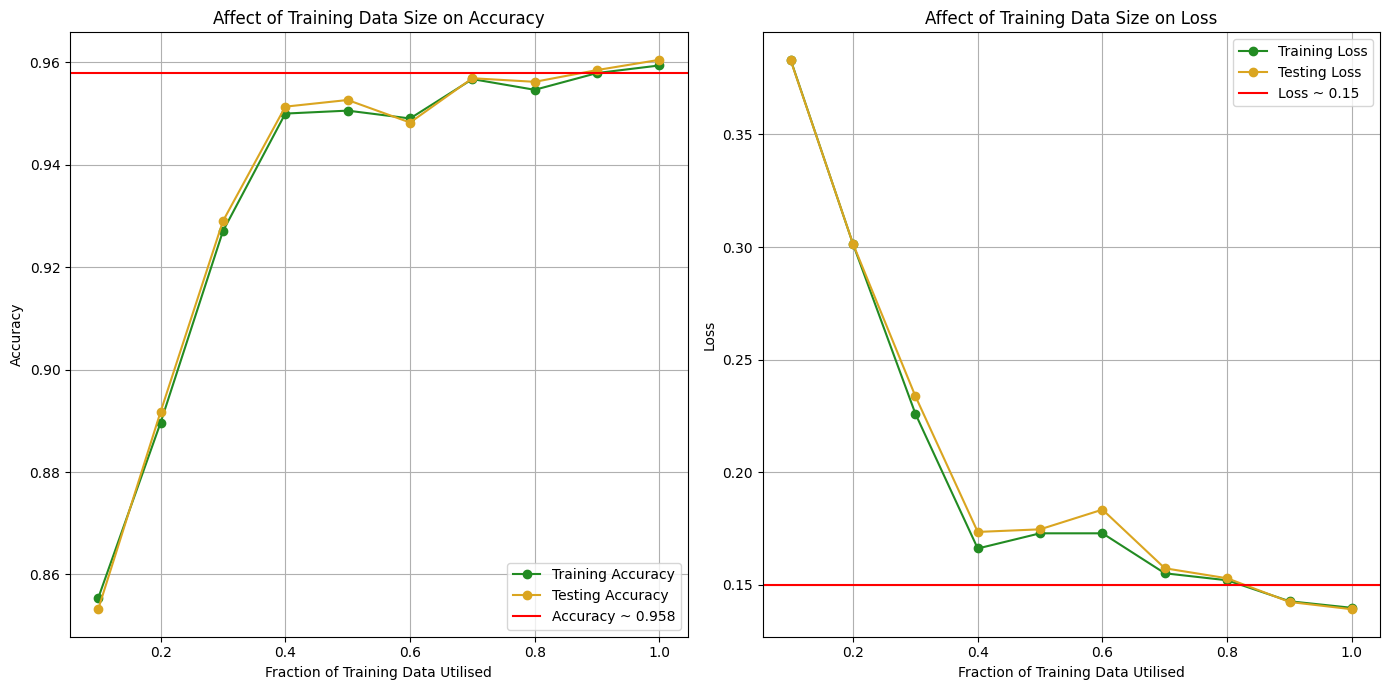

In [5]:
plt.figure(figsize = (14, 7))
plt.subplot(1, 2, 1)
plt.plot(fractions, trainAccuracy, marker = 'o', label = 'Training Accuracy', color = 'forestgreen')
plt.plot(fractions, testAccuracy, marker ='o', label = 'Testing Accuracy', color = 'goldenrod')
plt.axhline(y = 0.958, xmin = 0, xmax = epochs, linestyle= '-', color = 'r', label = "Accuracy ~ 0.958")
plt.title("Affect of Training Data Size on Accuracy")
plt.xlabel("Fraction of Training Data Utilised")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(fractions, trainLoss, marker = 'o', label = 'Training Loss', color = 'forestgreen')
plt.plot(fractions, testLoss, marker ='o', label = 'Testing Loss', color = 'goldenrod')
plt.axhline(y = 0.15, xmin = 0, xmax = epochs, linestyle= '-', color = 'r', label = "Loss ~ 0.15")
plt.title("Affect of Training Data Size on Loss")
plt.xlabel("Fraction of Training Data Utilised")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

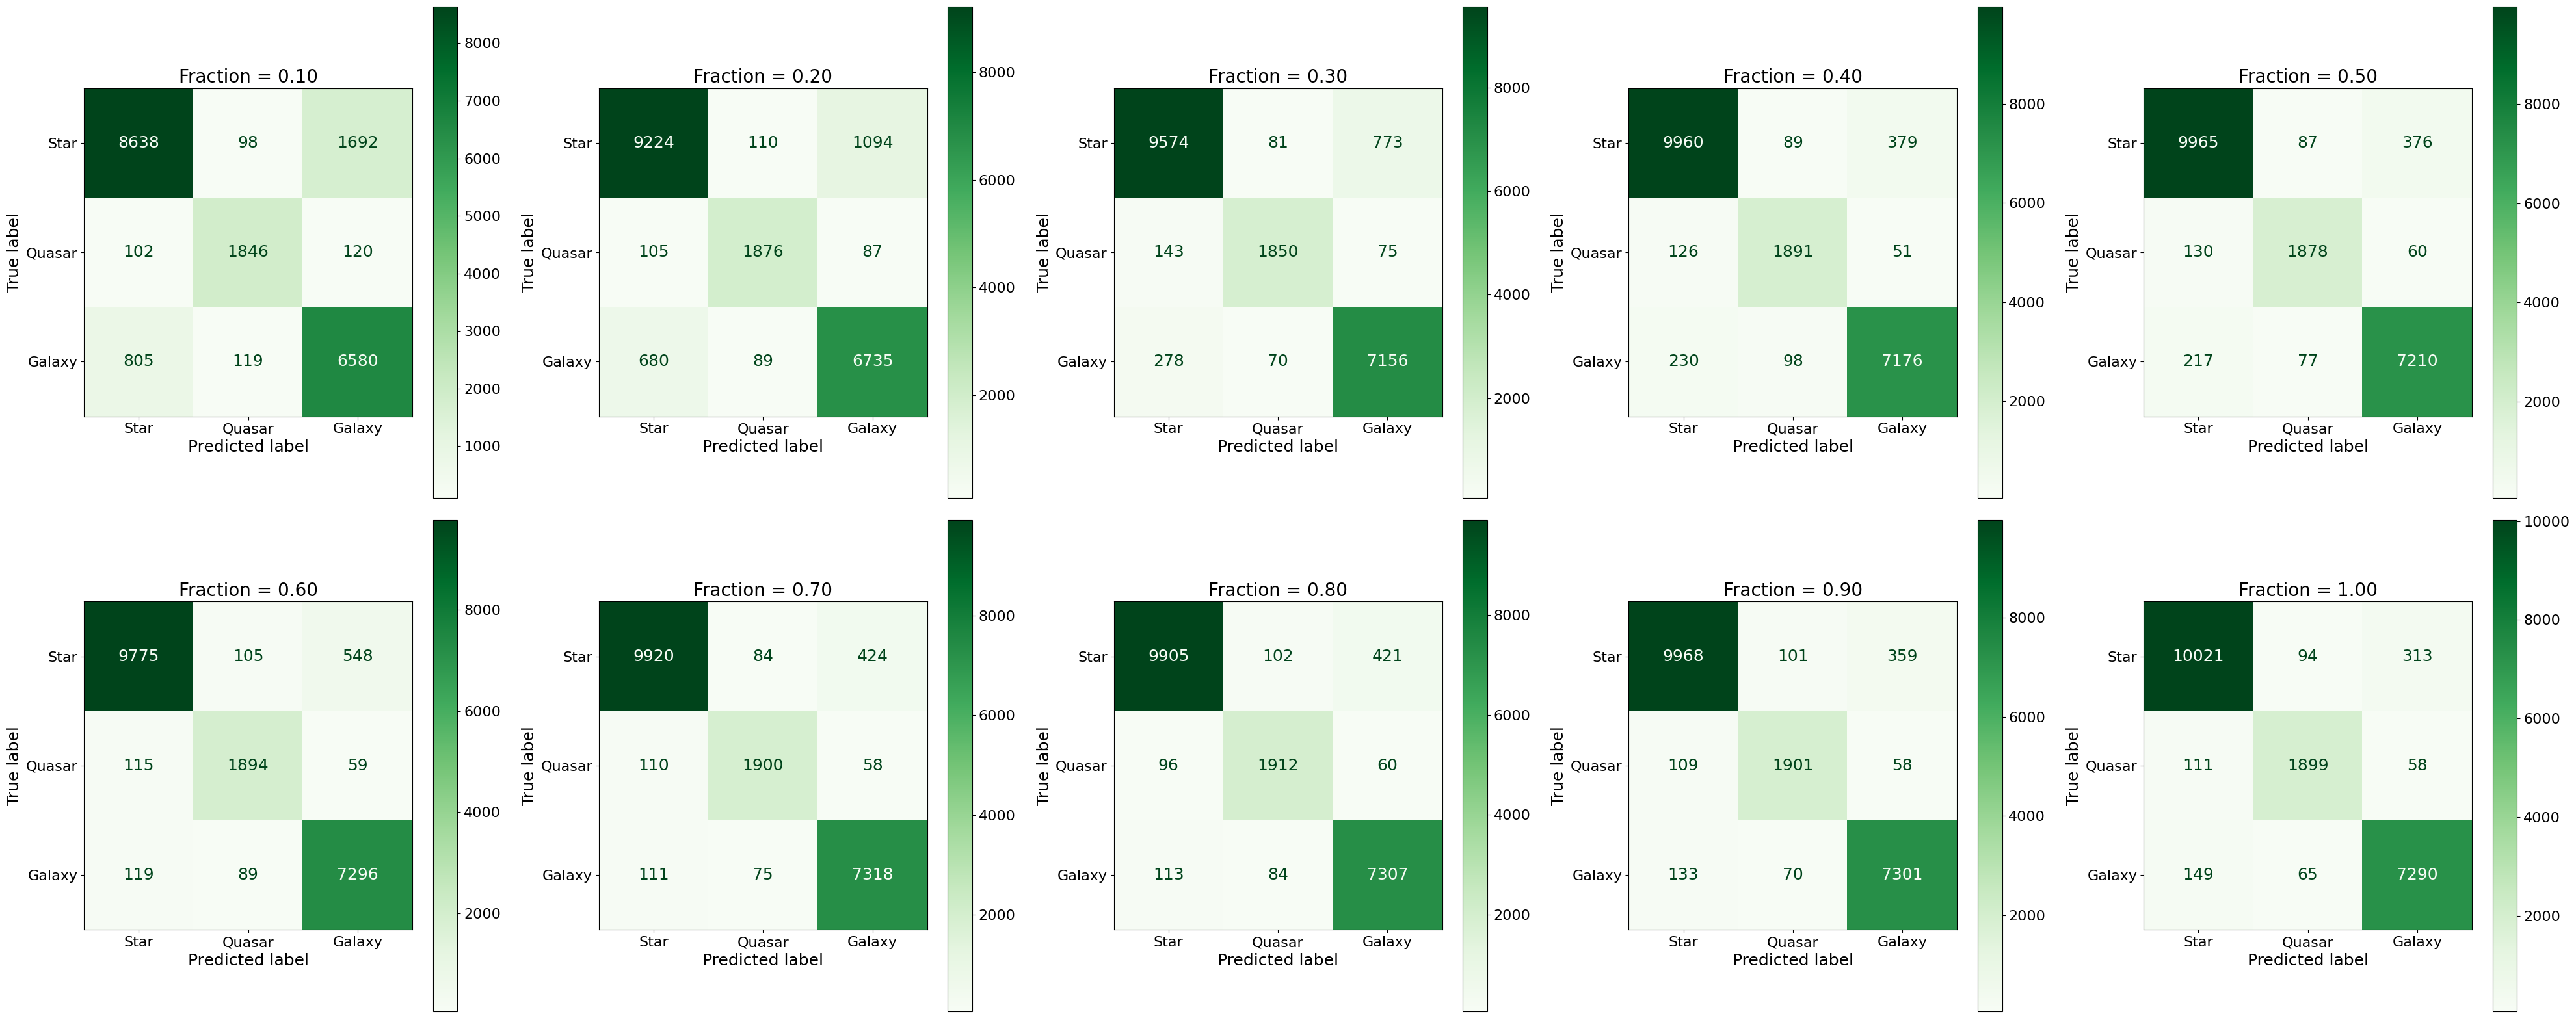

In [6]:
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

fig, axes = plt.subplots(2, 5, figsize=(40, 16))
axes = axes.flatten()

for ax, (i, confMatrix) in zip(axes, confusionMatrices):
    disp = ConfusionMatrixDisplay(
        confusion_matrix=confMatrix,
        display_labels=['Star', 'Quasar', 'Galaxy']
    )
    disp.plot(cmap="Greens", values_format="d", ax=ax, colorbar=True)
    ax.set_title(f"Fraction = {i:.2f}")

plt.tight_layout()
plt.show()

From these results, we can see two fairly clear things:
- **1.** the model performs worse with less available training data
- **2.** the model's training performance is somehow still relatively high even for low fractions of training data

The first point is to be expected, but the second is a slight surprise - this is however explainable quite easily with the concept of **overfitting**. This is where the model simply memorises the data and fits with the existing set - meaning the model seems to be performing well but in reality, if given unseen data, it'd perform poorly. This would greatly decrease the accuracy score of these models compared to our baseline model before, something we'd expect given the fraction of training data. However, given the very large amount of data in our dataset, these affects are less prevalent than they otherwise would be - even with 8% of the total data being trained on in `Fraction = 0.10`, the NN performs better than our non-NN in the first notebook, since this is still training with ~80,000 datapoints.

Now let's try and see what happens when we train with lots of data, 99% specifically, and see what the affect is overall.

In [7]:
plt.rcdefaults() #resetting plotting parameters to defaults

features = ['u', 'g', 'r', 'i', 'z'] #features we aim to target

x = data[features] #takes data from features and defines it as x
y = data['class'] #takes classes from data and defines it as y

labelEncoder = LabelEncoder() #defines encoding of target variables
yEncoded = labelEncoder.fit_transform(y) #encodes classes as Star - 0, Galaxy - 1, and Quasar - 2

scaler = StandardScaler() #defines standardisation
xScaled = scaler.fit_transform(x) #standardises x

test_size = 0.01 #defines test size
random_state = 12 #defines random state - allows for same results each time
xTrain, xTest, yTrain, yTest = dataSplitting(xScaled, yEncoded, test_size, random_state) #splits the data into a training set and a testing set

xTrainTensor = torch.tensor(xTrain, dtype = torch.float32) #converts training set to tensors
yTrainTensor = torch.tensor(yTrain, dtype = torch.long) 
xTestTensor = torch.tensor(xTest, dtype = torch.float32) #converts testing set to tensors
yTestTensor = torch.tensor(yTest, dtype = torch.long)

trainData = TensorDataset(xTrainTensor, yTrainTensor) #creates the training dataset
testData = TensorDataset(xTestTensor, yTestTensor) #creates the testing dataset
trainLoader = DataLoader(trainData, batch_size = 64, shuffle = True) #loads the training dataset, shuffle = True ensures mixing of data
testLoader =  DataLoader(testData, batch_size = 64, shuffle = False) #loads the testing dataset, shuffle = False preserves order

model = NeuralNetworkClassifier()

criteria = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr = 0.001)
epochs = 25
lossHistory = modelTraining(model, trainLoader, criteria, optimiser, epochs)

Epoch 1/25, loss = 0.594
Epoch 2/25, loss = 0.472
Epoch 3/25, loss = 0.430
Epoch 4/25, loss = 0.395
Epoch 5/25, loss = 0.372
Epoch 6/25, loss = 0.325
Epoch 7/25, loss = 0.287
Epoch 8/25, loss = 0.266
Epoch 9/25, loss = 0.259
Epoch 10/25, loss = 0.223
Epoch 11/25, loss = 0.218
Epoch 12/25, loss = 0.195
Epoch 13/25, loss = 0.197
Epoch 14/25, loss = 0.185
Epoch 15/25, loss = 0.172
Epoch 16/25, loss = 0.176
Epoch 17/25, loss = 0.175
Epoch 18/25, loss = 0.164
Epoch 19/25, loss = 0.177
Epoch 20/25, loss = 0.165
Epoch 21/25, loss = 0.165
Epoch 22/25, loss = 0.170
Epoch 23/25, loss = 0.159
Epoch 24/25, loss = 0.162
Epoch 25/25, loss = 0.159


Accuracy Score: 0.96
Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.99      0.95      0.97       568
         QSO       0.97      0.90      0.93       103
        STAR       0.92      0.99      0.95       329

    accuracy                           0.96      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.96      0.96      1000
 



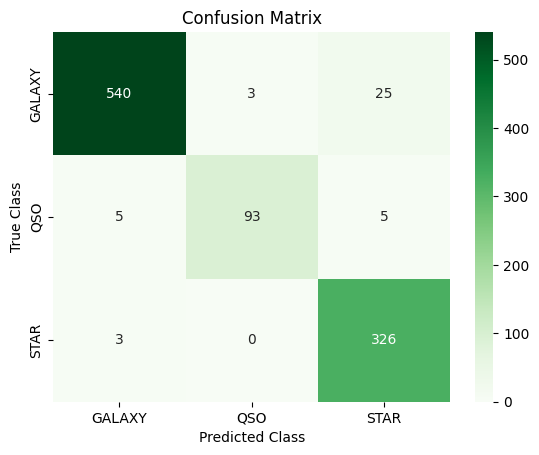

In [8]:
modelEvaluationNN(model, testLoader, labelEncoder)

Compared to the last notebook, this still performs well, giving the exact same accuracy as before, `96%`. It also gives a higher precision for the `QSO` class, but less for a `STAR` and the same for a `GALAXY` - giving the same recall and f1-score. Given the very large amount of data this isn't a surprise as it'll account for some degree of class bias - something we address in the following question!

## 2. Affect of balance of classes in a classification problem on a neural network ##

The balance of classes within a classification problem can affect how our NN performs dramatically depending on how the classes lie. Most models will begin to favour the classes which are more represented in the dataset. If a dataset, like ours, has three classes weighted 50:40:10, it'll be more likely to predict the first two classes in order to favour being overall accurate, as 9 times out of 10 it'll be one of the two options. This is what we plan to account for. To begin, we look at how our classes are distributed:

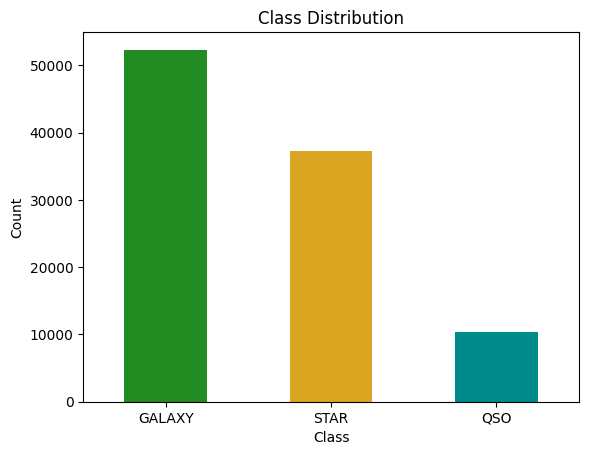

In [9]:
data['class'].value_counts().plot(kind='bar', color = ['forestgreen', 'goldenrod', 'darkcyan'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation = 0)
plt.show()

As seen in the above plot, our classes are distributed roughly 50:40:10 as a ratio as we said. To try and stop this class balance having an affect, we balance our classes to be equal - using all the `QSO` data, and equal sized chunks of the `GALAXY` and `STAR` data.

Now let's evaluate the model's performance without this balancing to determine a difference later.

In [10]:
features = ['u', 'g', 'r', 'i', 'z'] #features we aim to target

x = data[features] #takes data from features and defines it as x
y = data['class'] #takes classes from data and defines it as y

labelEncoder = LabelEncoder() #defines encoding of target variables
yEncoded = labelEncoder.fit_transform(y) #encodes classes as Star - 0, Galaxy - 1, and Quasar - 2

scaler = StandardScaler() #defines standardisation
xScaled = scaler.fit_transform(x) #standardises x

test_size = 0.2 #defines test size
random_state = 12 #defines random state - allows for same results each time
xTrain, xTest, yTrain, yTest = dataSplitting(xScaled, yEncoded, test_size, random_state) #splits the data into a training set and a testing set

xTrainTensor = torch.tensor(xTrain, dtype = torch.float32) #converts training set to tensors
yTrainTensor = torch.tensor(yTrain, dtype = torch.long) 
xTestTensor = torch.tensor(xTest, dtype = torch.float32) #converts testing set to tensors
yTestTensor = torch.tensor(yTest, dtype = torch.long)

trainData = TensorDataset(xTrainTensor, yTrainTensor) #creates the training dataset
testData = TensorDataset(xTestTensor, yTestTensor) #creates the testing dataset
trainLoader = DataLoader(trainData, batch_size = 64, shuffle = True) #loads the training dataset, shuffle = True ensures mixing of data
testLoader =  DataLoader(testData, batch_size = 64, shuffle = False) #loads the testing dataset, shuffle = False preserves order

model = NeuralNetworkClassifier()

criteria = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr = 0.001)
epochs = 25
lossHistory = modelTraining(model, trainLoader, criteria, optimiser, epochs)

Epoch 1/25, loss = 0.612
Epoch 2/25, loss = 0.483
Epoch 3/25, loss = 0.433
Epoch 4/25, loss = 0.399
Epoch 5/25, loss = 0.388
Epoch 6/25, loss = 0.350
Epoch 7/25, loss = 0.300
Epoch 8/25, loss = 0.268
Epoch 9/25, loss = 0.261
Epoch 10/25, loss = 0.229
Epoch 11/25, loss = 0.232
Epoch 12/25, loss = 0.216
Epoch 13/25, loss = 0.219
Epoch 14/25, loss = 0.209
Epoch 15/25, loss = 0.193
Epoch 16/25, loss = 0.192
Epoch 17/25, loss = 0.189
Epoch 18/25, loss = 0.195
Epoch 19/25, loss = 0.180
Epoch 20/25, loss = 0.183
Epoch 21/25, loss = 0.174
Epoch 22/25, loss = 0.173
Epoch 23/25, loss = 0.163
Epoch 24/25, loss = 0.165
Epoch 25/25, loss = 0.164


Accuracy Score: 0.96
Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.98      0.95      0.96     10428
         QSO       0.93      0.92      0.92      2068
        STAR       0.94      0.97      0.96      7504

    accuracy                           0.96     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.96      0.96      0.96     20000
 



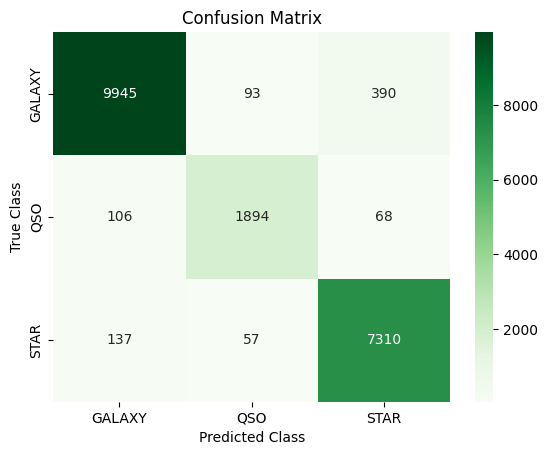

In [11]:
modelEvaluationNN(model, testLoader, labelEncoder)

From this, we see that the `QSO` class is being under-represented, with the precision, recall and f1-score being lower than all other classes. If we can improve these values, we will have confirmation that classes are being biased because of their prevalence. We will do this by under-representing the `STAR` and `GALAXY` classes and run our model once again - done below.

In [12]:
features = ['u', 'g', 'r', 'i', 'z'] #features we aim to target

x = data[features] #takes data from features and defines it as x
y = data['class'] #takes classes from data and defines it as y

labelEncoder = LabelEncoder() #defines encoding of target variables
yEncoded = labelEncoder.fit_transform(y) #encodes classes as Star - 0, Galaxy - 1, and Quasar - 2

scaler = StandardScaler() #defines standardisation
xScaled = scaler.fit_transform(x) #standardises x

test_size = 0.2 #defines test size
random_state = 12 #defines random state - allows for same results each time
xTrain, xTest, yTrain, yTest = dataSplitting(xScaled, yEncoded, test_size, random_state) #splits the data into a training set and a testing set

starIndex = np.where(yTrain == 0)[0] #finds instances of stars
galaxyIndex = np.where(yTrain == 1)[0] #finds instances of galaxies
quasarIndex = np.where(yTrain == 2)[0] #finds instances of quasars

numStar = len(starIndex) #number of stars
numGalaxy = len(galaxyIndex) #number of galaxies
numQSO = len(quasarIndex) #numbers of quasars

numStarsSample = min(numStar, numQSO) #ensures sample is smallest
numGalaxiesSample = min(numGalaxy, numQSO)

starIndexUndersample = np.random.choice(starIndex, size = numStarsSample, replace = False)
galaxyIndexUndersample = np.random.choice(galaxyIndex, size = numGalaxiesSample, replace = False)

undersampledIndex = np.concatenate([starIndexUndersample, galaxyIndexUndersample, quasarIndex])

xTrainBalanced = xTrain[undersampledIndex]
yTrainBalanced = yTrain[undersampledIndex]

xTrainTensor = torch.tensor(xTrainBalanced, dtype = torch.float32) #converts training set to tensors
yTrainTensor = torch.tensor(yTrainBalanced, dtype = torch.long) 
xTestTensor = torch.tensor(xTest, dtype = torch.float32) #converts testing set to tensors
yTestTensor = torch.tensor(yTest, dtype = torch.long)

trainData = TensorDataset(xTrainTensor, yTrainTensor) #creates the training dataset
testData = TensorDataset(xTestTensor, yTestTensor) #creates the testing dataset
trainLoader = DataLoader(trainData, batch_size = 64, shuffle = True) #loads the training dataset, shuffle = True ensures mixing of data
testLoader =  DataLoader(testData, batch_size = 64, shuffle = False) #loads the testing dataset, shuffle = False preserves order

model = NeuralNetworkClassifier()

criteria = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr = 0.001)
epochs = 25
lossHistory = modelTraining(model, trainLoader, criteria, optimiser, epochs)

Epoch 1/25, loss = 0.628
Epoch 2/25, loss = 0.496
Epoch 3/25, loss = 0.445
Epoch 4/25, loss = 0.452
Epoch 5/25, loss = 0.418
Epoch 6/25, loss = 0.385
Epoch 7/25, loss = 0.369
Epoch 8/25, loss = 0.335
Epoch 9/25, loss = 0.323
Epoch 10/25, loss = 0.284
Epoch 11/25, loss = 0.260
Epoch 12/25, loss = 0.252
Epoch 13/25, loss = 0.236
Epoch 14/25, loss = 0.226
Epoch 15/25, loss = 0.225
Epoch 16/25, loss = 0.218
Epoch 17/25, loss = 0.206
Epoch 18/25, loss = 0.195
Epoch 19/25, loss = 0.192
Epoch 20/25, loss = 0.188
Epoch 21/25, loss = 0.182
Epoch 22/25, loss = 0.180
Epoch 23/25, loss = 0.180
Epoch 24/25, loss = 0.176
Epoch 25/25, loss = 0.171


Accuracy Score: 0.95
Classification Report:
              precision    recall  f1-score   support

      GALAXY       0.98      0.94      0.96     10428
         QSO       0.92      0.93      0.92      2068
        STAR       0.92      0.98      0.95      7504

    accuracy                           0.95     20000
   macro avg       0.94      0.95      0.94     20000
weighted avg       0.95      0.95      0.95     20000
 



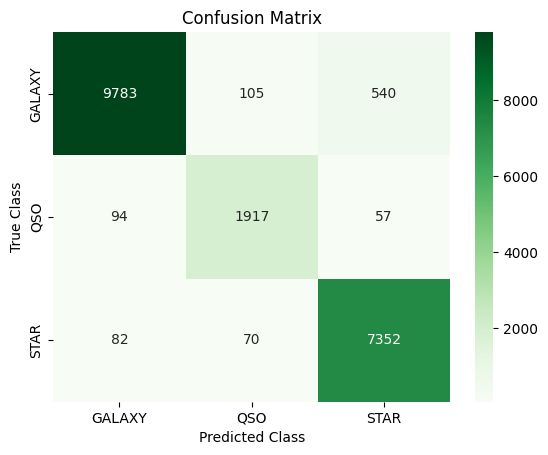

In [13]:
modelEvaluationNN(model, testLoader, labelEncoder)

As can be seen in our `Classification Report` and `Confusion Matrix`, there are more correct predicitions of the Quasars, with less Stars and Galaxies correctly predicted. This implies there was a degree of class bias for the stars and galaxies, so the quasars were being under-represented by our NN.

Interestingly, the overall accuracy slightly decreased (0.96 to 0.95), the `f1-score` and `recall` haven't visibily changed, but it can be implied they increased with the `QSO` class - the main reason this isn't shown is because of the large dataset size.

## Conclusions we have reached

Within this final notebook, we have taken a look at how factors affect the performance of our NN, these being:

- The affects of changing the amount of training data
- The affects of the balance of classes within our dataset

Through our findings, we found that the amount of data available to training affects the accuracy and loss significantly, with the model overfitting when training data is insufficient - decreasing the accuracy despite the illusion of performance. We also found that using lots of training data makes our accuracy more consistent across classes.

Furthermore, we looked at the balance of classes within our dataset, seeing how an imbalance will affect our modelling - with `QSO` being our unfavoured class. We found our base model biased the `STAR` and `GALAXY` class, and used undersampling to try and rectify this - which worked but the affect was limited due to the size of our dataset.

We have shown that we must take factors like these into consideration when using a NN and machine learning models, in order to increase the true performance.